<a href="https://colab.research.google.com/github/LinaManel/CO2-FORCASTING-PROJECT/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import warnings
import itertools
warnings.filterwarnings("ignore")

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from keras.preprocessing.sequence import TimeseriesGenerator

# Pour Transformer (lib légère pour séries temporelles)
# from transformers import TimeSeriesTransformer

In [13]:
ts = pd.read_csv("/MER_T12_06.csv")
ts.head()
ts

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLEIEUS,197301,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1,CLEIEUS,197302,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
2,CLEIEUS,197303,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
3,CLEIEUS,197304,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
4,CLEIEUS,197305,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
...,...,...,...,...,...,...
5089,TXEIEUS,201603,115.997,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
5090,TXEIEUS,201604,113.815,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
5091,TXEIEUS,201605,129.44,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
5092,TXEIEUS,201606,172.074,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [14]:
ts.isnull().sum()

,0
MSN,0
YYYYMM,0
Value,0
Column_Order,0
Description,0
Unit,0


In [15]:
# Strip whitespace and keep only the first 6 characters (in case something is hiding)
ts['YYYYMM'] = ts['YYYYMM'].astype(str).str.strip().str[:6]

# Then try converting again
ts['Date'] = pd.to_datetime(ts['YYYYMM'], format='%Y%m', errors='coerce')

# Extract year and month
ts['Year'] = ts['Date'].dt.year
ts['Month'] = ts['Date'].dt.month

ts.drop(columns='YYYYMM', inplace=True)

ts.head(15)

,MSN,Value,Column_Order,Description,Unit,Date,Year,Month
0,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-01-01,1973.0,1.0
1,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-02-01,1973.0,2.0
2,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-03-01,1973.0,3.0
3,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-04-01,1973.0,4.0
4,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-05-01,1973.0,5.0
5,CLEIEUS,66.538,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-06-01,1973.0,6.0
6,CLEIEUS,72.626,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-07-01,1973.0,7.0
7,CLEIEUS,75.181,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-08-01,1973.0,8.0
8,CLEIEUS,68.397,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-09-01,1973.0,9.0
9,CLEIEUS,67.668,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-10-01,1973.0,10.0


In [16]:
ts.isnull().sum()

,0
MSN,0
Value,0
Column_Order,0
Description,0
Unit,0
Date,387
Year,387
Month,387


In [17]:
ts.dropna(inplace = True)

In [18]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4707 entries, 0 to 5093
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MSN           4707 non-null   object        
 1   Value         4707 non-null   object        
 2   Column_Order  4707 non-null   int64         
 3   Description   4707 non-null   object        
 4   Unit          4707 non-null   object        
 5   Date          4707 non-null   datetime64[ns]
 6   Year          4707 non-null   float64       
 7   Month         4707 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 331.0+ KB


In [19]:
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts['Year'] = ts['Year'].astype(int)
ts['Month'] = ts['Month'].astype(int)
ts.head()

,MSN,Value,Column_Order,Description,Unit,Date,Year,Month
0,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-01-01,1973,1
1,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-02-01,1973,2
2,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-03-01,1973,3
3,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-04-01,1973,4
4,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-05-01,1973,5


In [20]:
ts.duplicated().sum()

np.int64(0)

In [21]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4707 entries, 0 to 5093
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MSN           4707 non-null   object        
 1   Value         4323 non-null   float64       
 2   Column_Order  4707 non-null   int64         
 3   Description   4707 non-null   object        
 4   Unit          4707 non-null   object        
 5   Date          4707 non-null   datetime64[ns]
 6   Year          4707 non-null   int64         
 7   Month         4707 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 331.0+ KB


# Vis

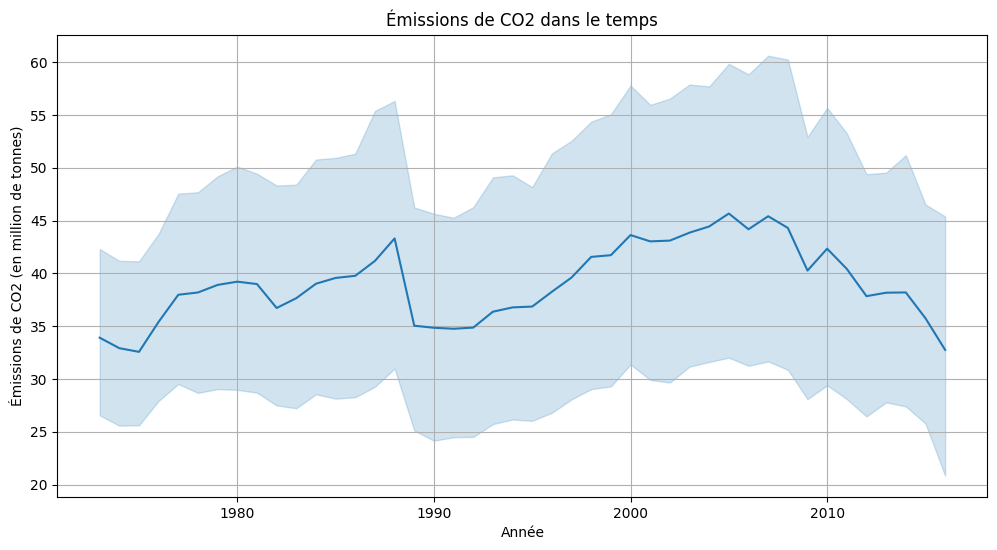

In [22]:
# Affichage graphique
plt.figure(figsize=(12, 6))
sns.lineplot(data=ts, x='Year', y='Value')
plt.title("Émissions de CO2 dans le temps")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (en million de tonnes)")
plt.grid()
plt.show()

In [23]:
Energy_sources = ts.groupby('Description')
Energy_sources.head()

,MSN,Value,Column_Order,Description,Unit,Date,Year,Month
0,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-01-01,1973,1
1,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-02-01,1973,2
2,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-03-01,1973,3
3,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-04-01,1973,4
4,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-05-01,1973,5
566,NNEIEUS,12.175,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-01-01,1973,1
567,NNEIEUS,11.708,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-02-01,1973,2
568,NNEIEUS,13.994,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-03-01,1973,3
569,NNEIEUS,14.627,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-04-01,1973,4
570,NNEIEUS,17.344,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-05-01,1973,5


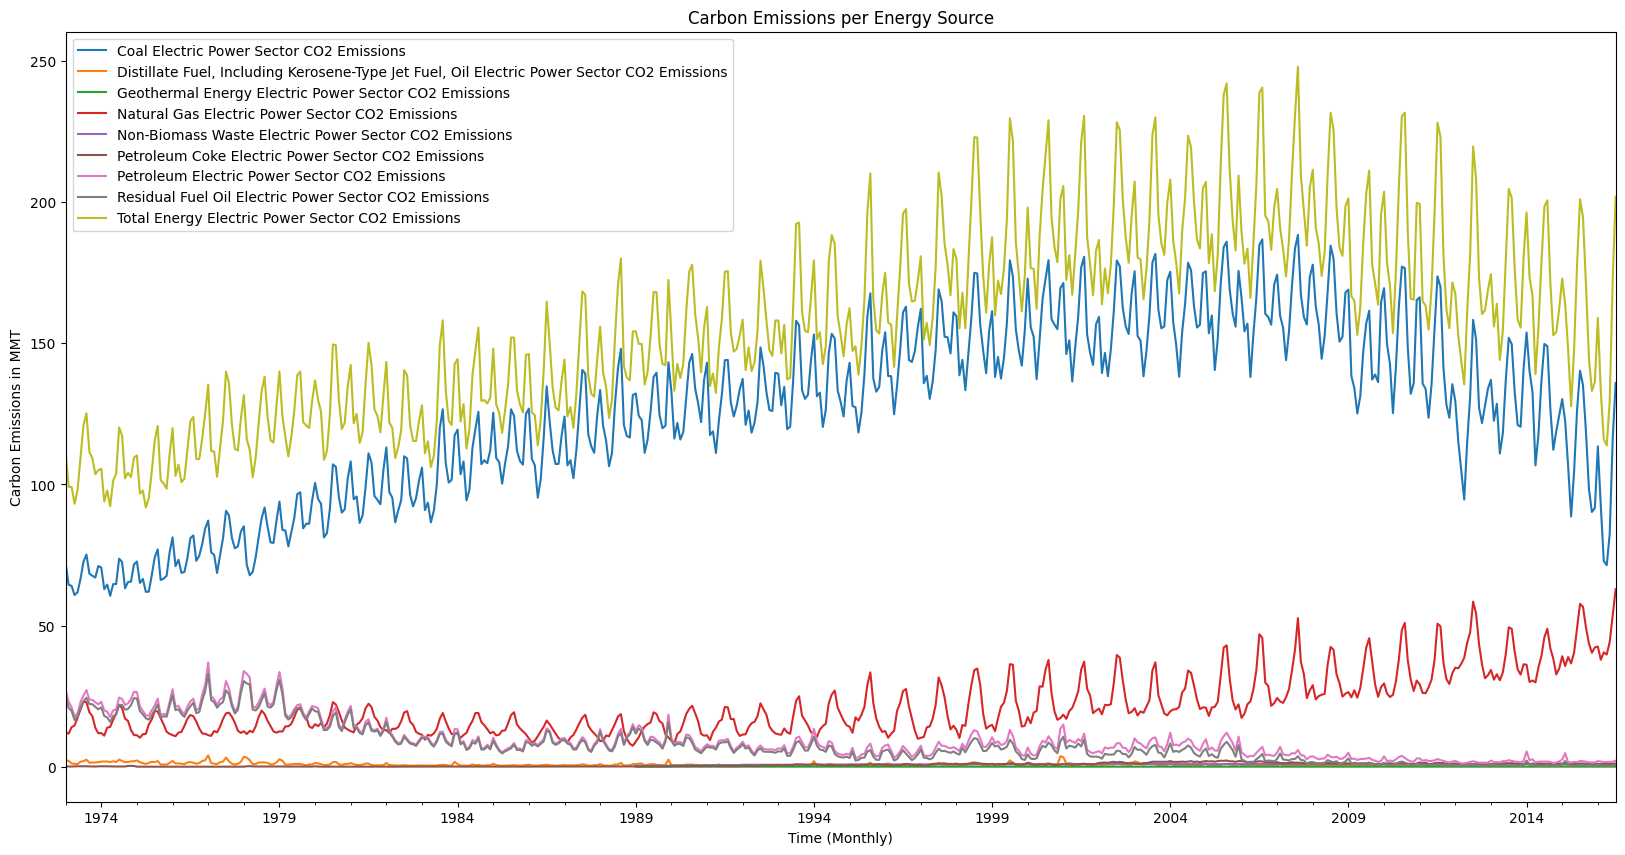

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

for desc, group in Energy_sources:
    group.plot(
        x='Date',
        y='Value',
        label=desc,
        ax=ax,
        title='Carbon Emissions per Energy Source',
        fontsize=10
    )

ax.set_xlabel('Time (Monthly)')
ax.set_ylabel('Carbon Emissions in MMT')
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.legend(fontsize=10)


Individually, we can visualize the trend and seasonality effect on CO2 emission from each energy source. For example, the CO2 emission from coal shows a trend of increment from 1973 to 2006 and then declines till 2016.

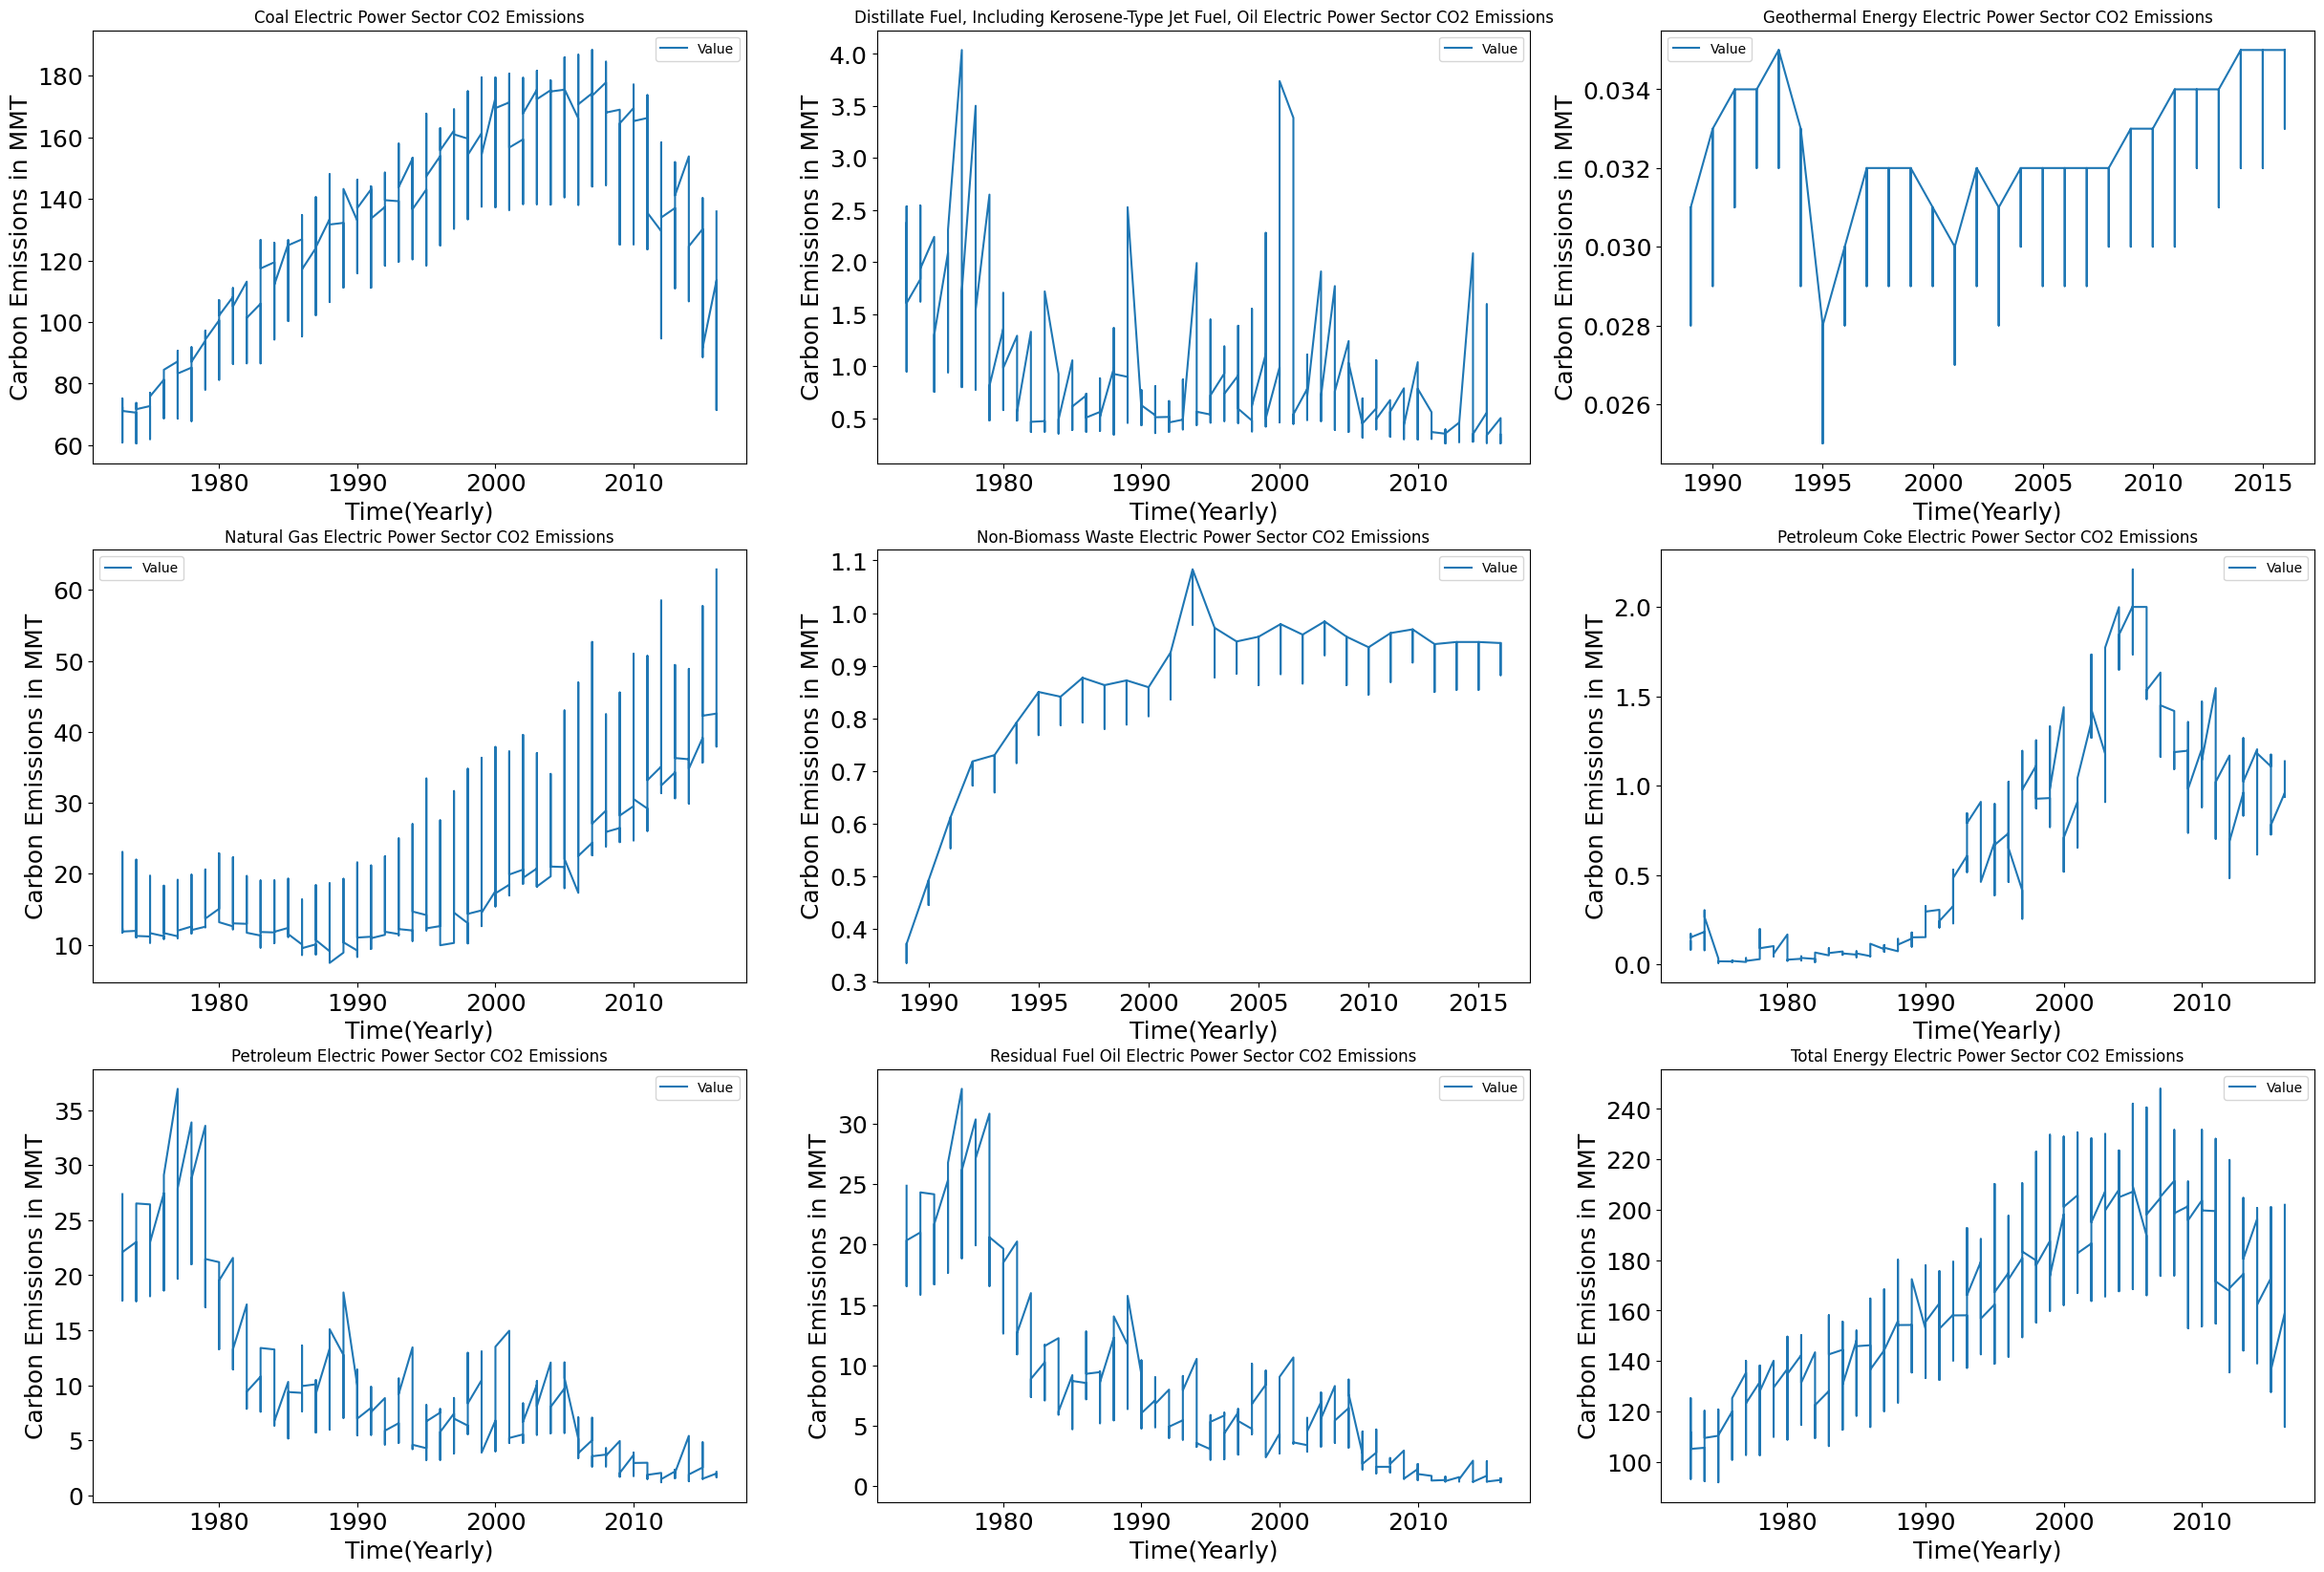

In [25]:
fig, axes = plt.subplots(3,3, figsize = (30, 20))
for (desc, group), ax in zip(Energy_sources, axes.flatten()):
    group.plot(x = 'Year', y='Value',ax = ax, title=desc, fontsize = 18)
    ax.set_xlabel('Time(Yearly)')
    ax.set_ylabel('Carbon Emissions in MMT')
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

In recent years, the natural gas consumption has been increasing. However, the use of coal for power generation has been declining. The plots of CO2 emissions from coal and natural gas show this trend, while declining the CO2 contribution from coal, there is an increment in the contribution of CO2 emission from natural gas.


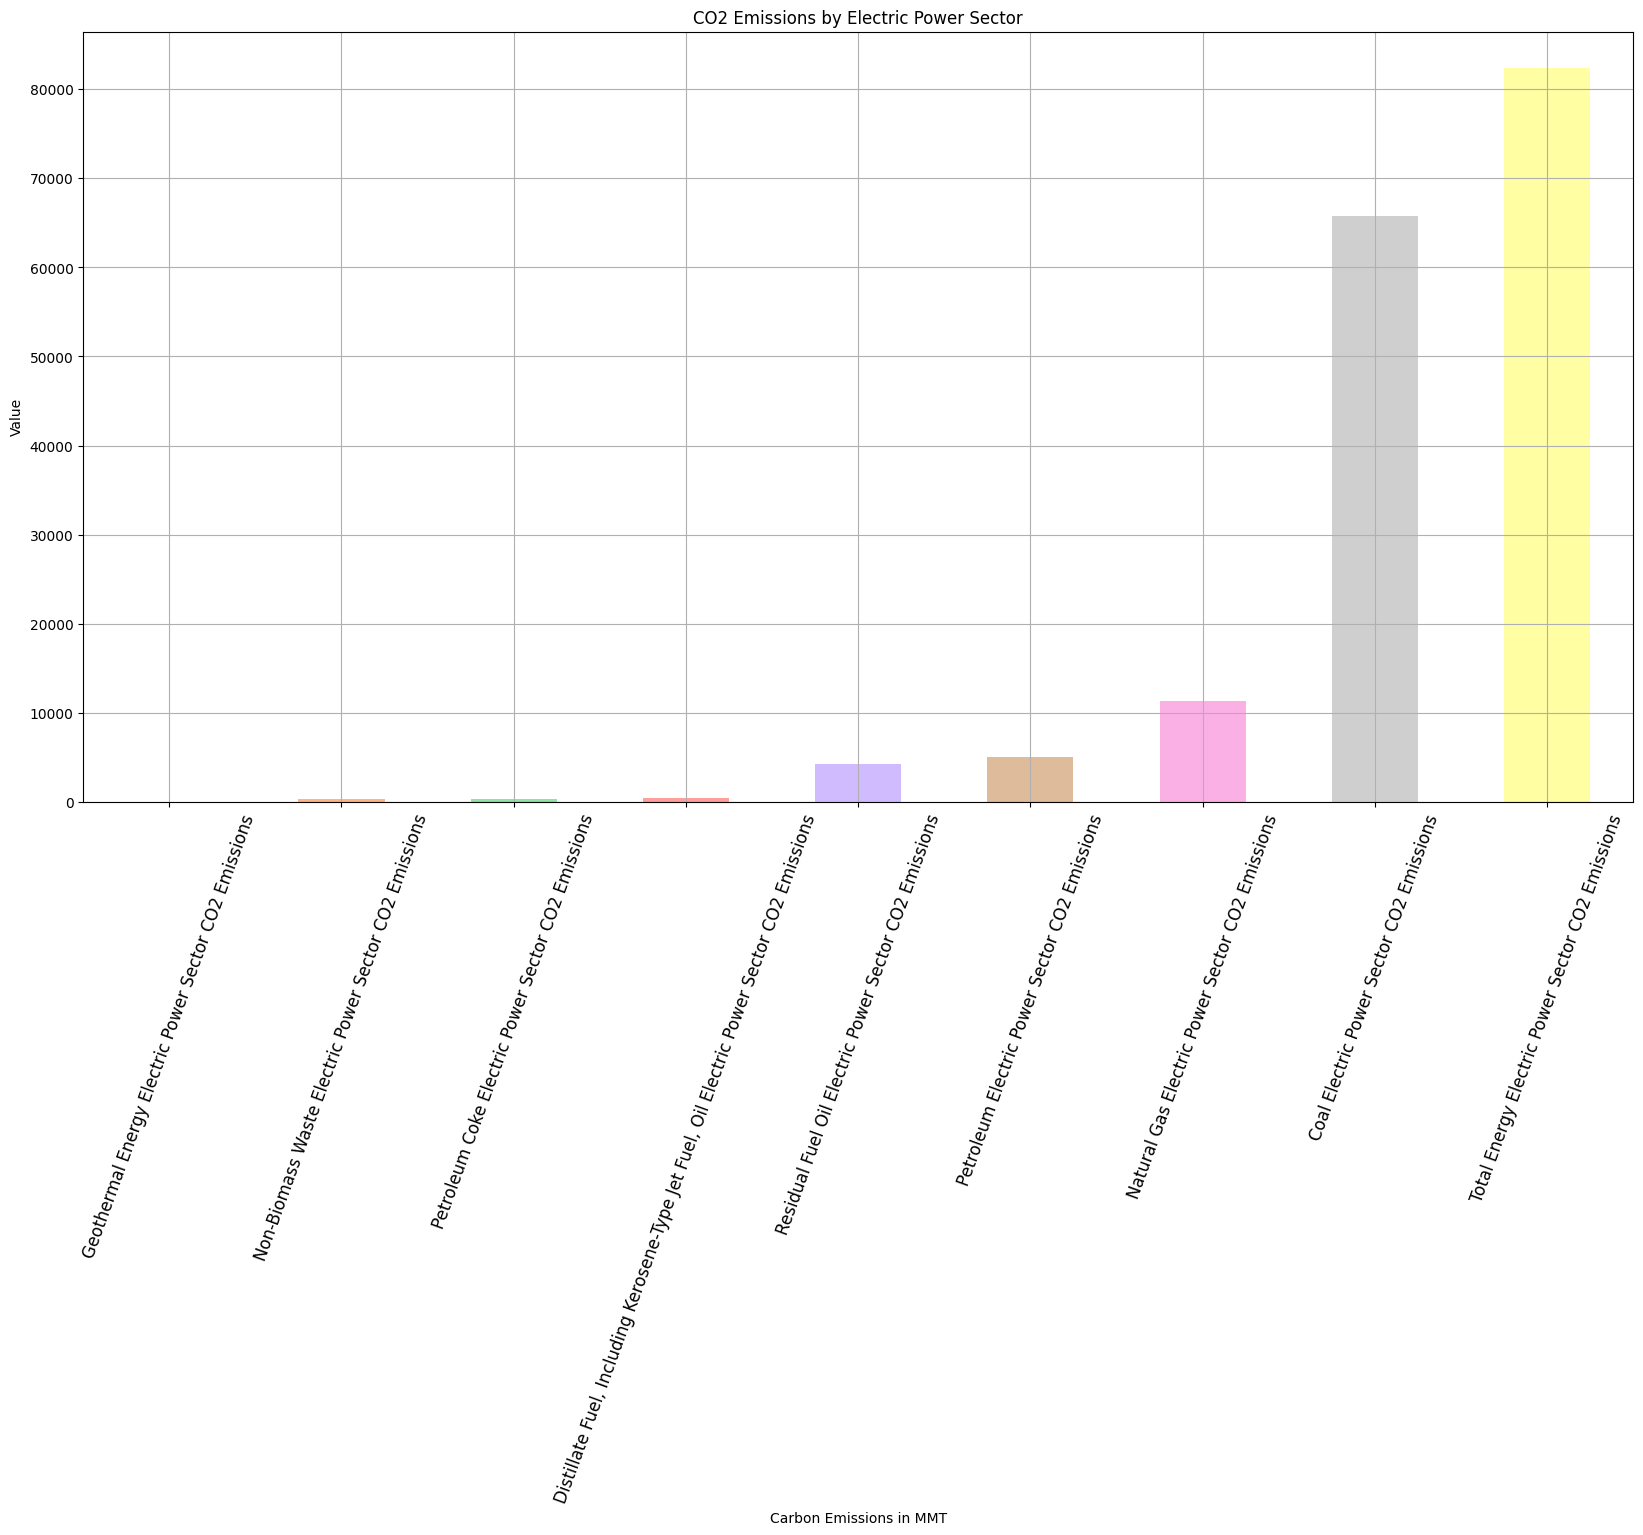

In [26]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()
# Génération de la palette de couleurs
colors = sns.color_palette("pastel", len(CO2_per_source))

# Création de la figure et de l'axe
plt.figure(figsize=(20, 10))

# Tracé de la ligne
CO2_per_source.plot(kind='bar', color=colors)

# Ajout du titre et des labels
plt.title("CO2 Emissions by Electric Power Sector")
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel('Carbon Emissions in MMT')
plt.ylabel('Value')

# Ajouter une grille pour mieux visualiser
plt.grid(True)

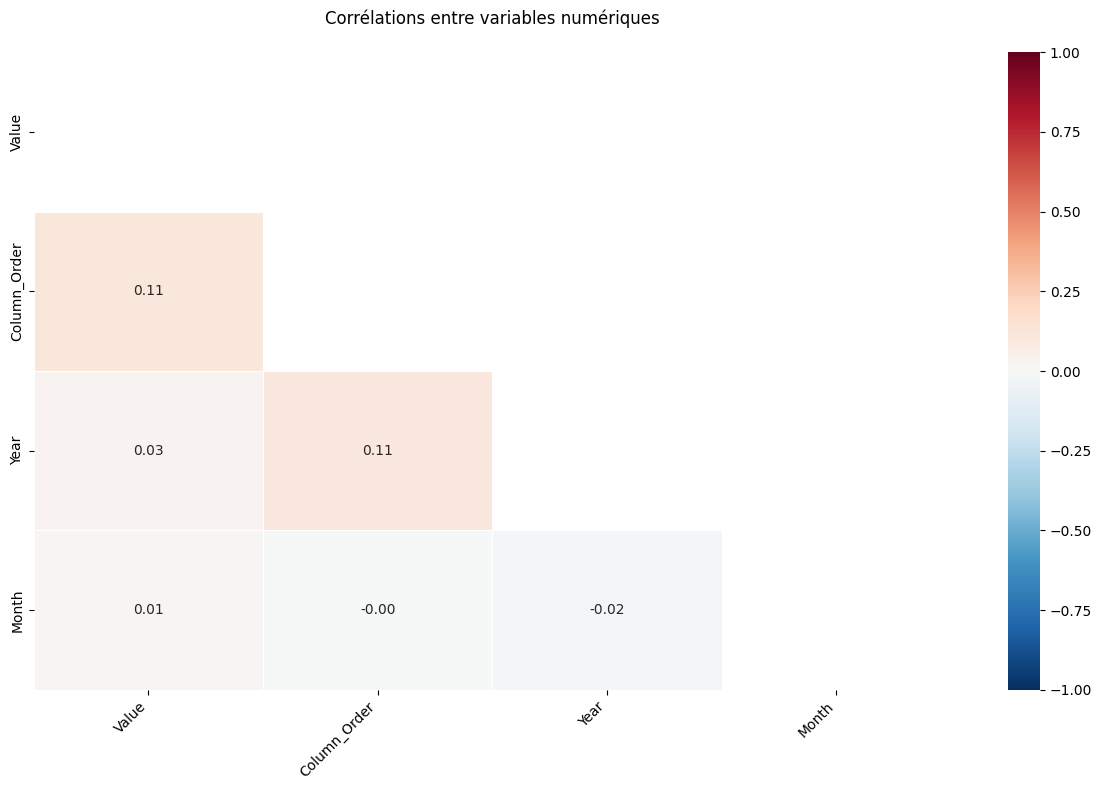

In [27]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = ts.select_dtypes(include=['float64', 'int64']).columns
df_numeric = ts[numeric_cols].dropna()  # Supprimer les NaN

matrix_corr = df_numeric.corr(method='pearson')

# Masque pour triangularisation (éviter la redondance)
mask = np.triu(np.ones_like(matrix_corr, dtype=bool))

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_corr,
            mask=mask,
            cmap='RdBu_r',
            annot=True,
            fmt=".2f",  # Format à 2 décimales
            linewidths=0.5,
            vmin=-1, vmax=1,
            center=0)

plt.title("Corrélations entre variables numériques", pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
# Pivot the table: Rows=Year, Columns=Emission Type, Values=CO2 Value
pivot_table = ts.pivot_table(
    index='Year',         # Time axis (adjust if needed)
    columns='Description', # Emission types (Coal, Oil, Gas)
    values='Value',       # CO2 values
    aggfunc='mean'        # Use mean if duplicates exist
)

pivot_table

Description,Coal Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Geothermal Energy Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions,Petroleum Coke Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
Year,,,,,,,,,
1973,67.649250,1.659500,NaN,16.571333,NaN,0.129833,22.975167,21.186000,107.196083
1974,66.677583,1.877167,NaN,15.559833,NaN,0.160167,21.982917,19.945667,104.220250
1975,68.645000,1.375583,NaN,14.324333,NaN,0.018083,20.682083,19.288167,103.651167
1976,75.945583,1.478167,NaN,13.935167,NaN,0.017417,22.718250,21.222667,112.598833
1977,80.178583,1.722500,NaN,14.518833,NaN,0.025000,25.480000,23.732250,120.177250
1978,79.993083,1.679250,NaN,14.576333,NaN,0.102000,26.068833,24.287417,120.638167
1979,87.975333,1.084167,NaN,15.973250,NaN,0.068833,21.488917,20.336250,125.437250
1980,94.716167,1.027917,NaN,16.703833,NaN,0.046000,17.222333,16.148250,128.642417
1981,98.364000,0.755500,NaN,16.491167,NaN,0.035583,14.406083,13.615000,129.261333


In [29]:
pivot_table.fillna(0)

Description,Coal Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Geothermal Energy Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions,Petroleum Coke Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
Year,,,,,,,,,
1973,67.649250,1.659500,0.000000,16.571333,0.000000,0.129833,22.975167,21.186000,107.196083
1974,66.677583,1.877167,0.000000,15.559833,0.000000,0.160167,21.982917,19.945667,104.220250
1975,68.645000,1.375583,0.000000,14.324333,0.000000,0.018083,20.682083,19.288167,103.651167
1976,75.945583,1.478167,0.000000,13.935167,0.000000,0.017417,22.718250,21.222667,112.598833
1977,80.178583,1.722500,0.000000,14.518833,0.000000,0.025000,25.480000,23.732250,120.177250
1978,79.993083,1.679250,0.000000,14.576333,0.000000,0.102000,26.068833,24.287417,120.638167
1979,87.975333,1.084167,0.000000,15.973250,0.000000,0.068833,21.488917,20.336250,125.437250
1980,94.716167,1.027917,0.000000,16.703833,0.000000,0.046000,17.222333,16.148250,128.642417
1981,98.364000,0.755500,0.000000,16.491167,0.000000,0.035583,14.406083,13.615000,129.261333


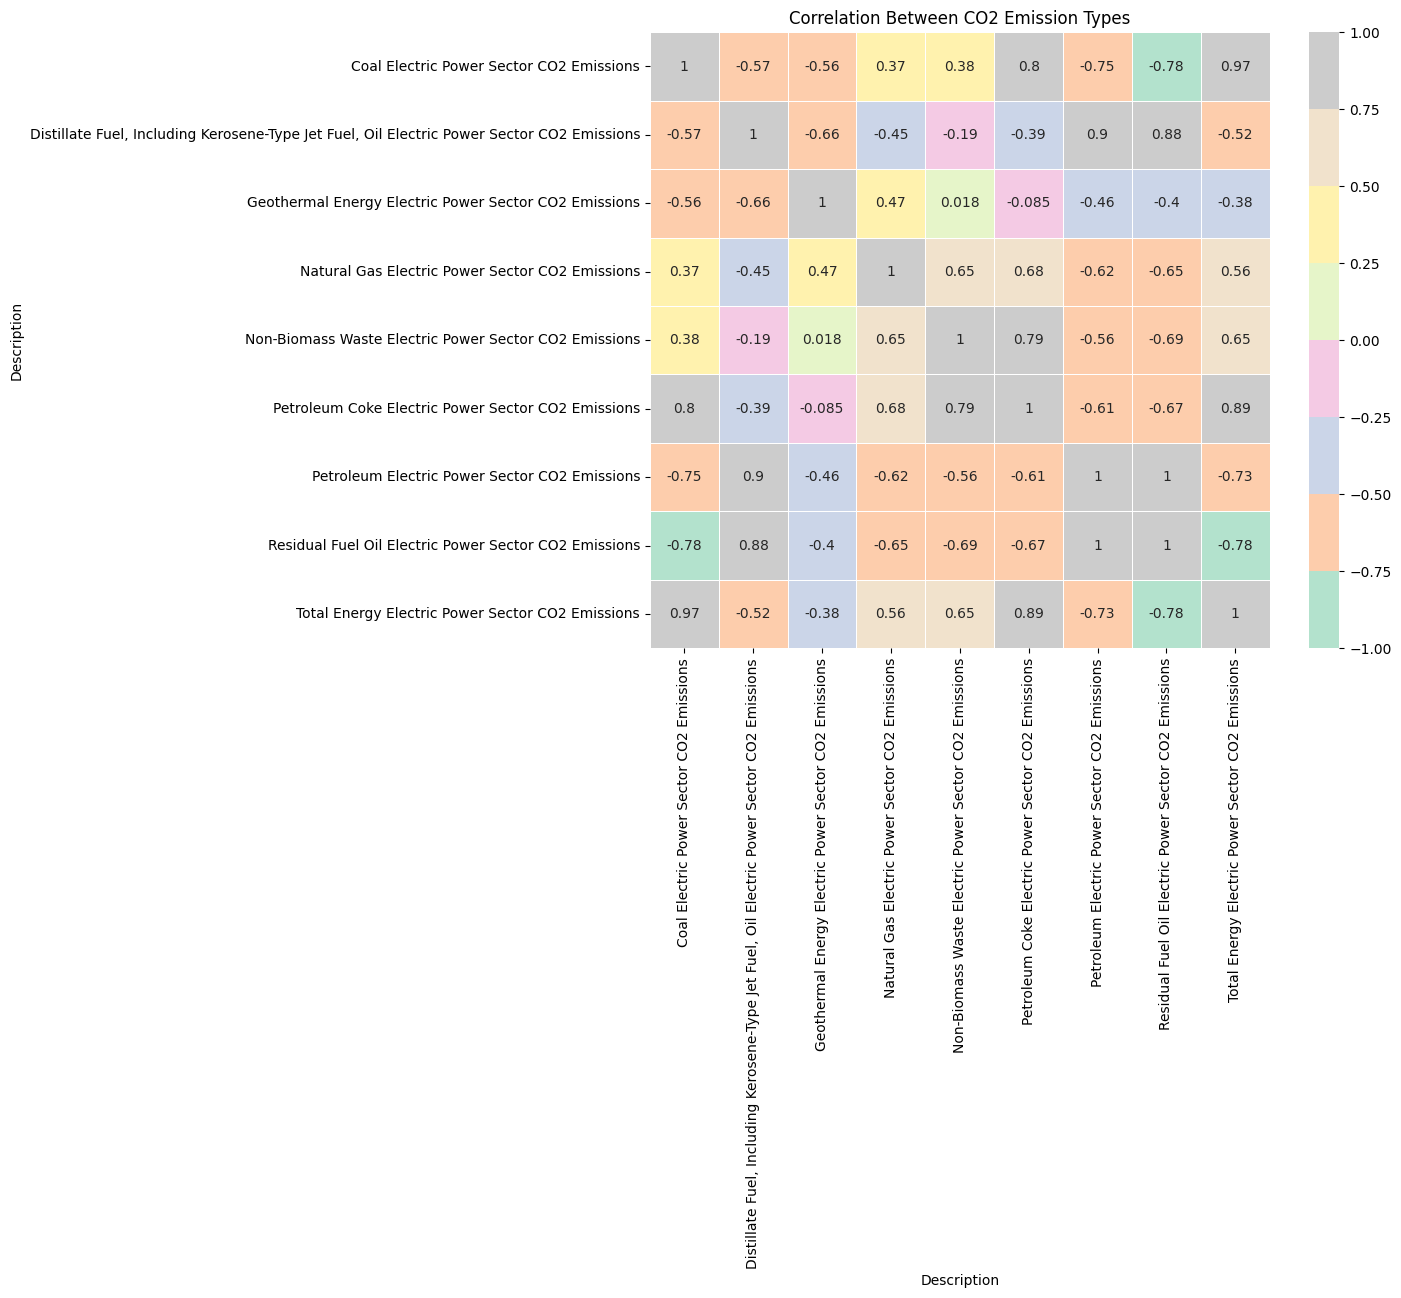

In [30]:
correlation_matrix = pivot_table.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,      # Show correlation values
    cmap='Pastel2',   # Red-Blue color scale
    vmin=-1, vmax=1, # Fix scale from -1 to 1
    linewidths=0.5
)
plt.title("Correlation Between CO2 Emission Types")
plt.show()

In [31]:
unwanted_values = ['Coal Electric Power Sector CO2 Emissions', 'Petroleum Electric Power Sector CO2 Emissions']
ts_cor = ts[~ts['Description'].isin(unwanted_values)]
ts_cor['Description'].value_counts()


,count
Description,
Natural Gas Electric Power Sector CO2 Emissions,523
"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",523
Petroleum Coke Electric Power Sector CO2 Emissions,523
Residual Fuel Oil Electric Power Sector CO2 Emissions,523
Geothermal Energy Electric Power Sector CO2 Emissions,523
Non-Biomass Waste Electric Power Sector CO2 Emissions,523
Total Energy Electric Power Sector CO2 Emissions,523


In [32]:
ts.describe()

,Value,Column_Order,Date,Year,Month
count,4323.000000,4707.000000,4707,4707.000000,4707.000000
mean,39.252449,5.000000,1994-10-01 02:36:56.443594624,1994.294455,6.466539
min,0.009000,1.000000,1973-01-01 00:00:00,1973.000000,1.000000
25%,0.730000,3.000000,1983-11-01 00:00:00,1983.000000,3.000000
50%,6.236000,5.000000,1994-10-01 00:00:00,1994.000000,6.000000
75%,40.638000,7.000000,2005-09-01 00:00:00,2005.000000,9.000000
max,247.995000,9.000000,2016-07-01 00:00:00,2016.000000,12.000000
std,61.128676,2.582263,NaN,12.584267,3.449024


In [33]:
ts_cor.describe()

,Value,Column_Order,Date,Year,Month
count,3277.000000,3661.000000,3661,3661.000000,3661.000000
mean,30.187046,5.428571,1994-10-01 02:36:56.443594624,1994.294455,6.466539
min,0.009000,2.000000,1973-01-01 00:00:00,1973.000000,1.000000
25%,0.478000,3.000000,1983-11-01 00:00:00,1983.000000,3.000000
50%,1.276000,5.000000,1994-10-01 00:00:00,1994.000000,6.000000
75%,19.448000,8.000000,2005-09-01 00:00:00,2005.000000,9.000000
max,247.995000,9.000000,2016-07-01 00:00:00,2016.000000,12.000000
std,57.801643,2.441477,NaN,12.584649,3.449129


In [34]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ts_cor["Scaled_CO2"] = scaler.fit_transform(ts_cor[["Value"]])
ts_cor

,MSN,Value,Column_Order,Description,Unit,Date,Year,Month,Scaled_CO2
566,NNEIEUS,12.175,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-01-01,1973,1,0.049059
567,NNEIEUS,11.708,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-02-01,1973,2,0.047176
568,NNEIEUS,13.994,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-03-01,1973,3,0.056394
569,NNEIEUS,14.627,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-04-01,1973,4,0.058947
570,NNEIEUS,17.344,2,Natural Gas Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-05-01,1973,5,0.069903
...,...,...,...,...,...,...,...,...,...
5089,TXEIEUS,115.997,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,2016-03-01,2016,3,0.467720
5090,TXEIEUS,113.815,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,2016-04-01,2016,4,0.458921
5091,TXEIEUS,129.440,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,2016-05-01,2016,5,0.521929
5092,TXEIEUS,172.074,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,2016-06-01,2016,6,0.693850


In [35]:
from sklearn.model_selection import TimeSeriesSplit

# Variables
X = ts_cor[['Scaled_CO2']].values
y = ts_cor[['Scaled_CO2']].values  # ici prédiction univariée de la même série
tscv = TimeSeriesSplit(n_splits=5)

# Visualiser les splits
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Split {i+1}")
    print(f"  Train: {train_index[0]} → {train_index[-1]} ({len(train_index)} samples)")
    print(f"  Test : {test_index[0]} → {test_index[-1]} ({len(test_index)} samples)")


Split 1
  Train: 0 → 610 (611 samples)
  Test : 611 → 1220 (610 samples)
Split 2
  Train: 0 → 1220 (1221 samples)
  Test : 1221 → 1830 (610 samples)
Split 3
  Train: 0 → 1830 (1831 samples)
  Test : 1831 → 2440 (610 samples)
Split 4
  Train: 0 → 2440 (2441 samples)
  Test : 2441 → 3050 (610 samples)
Split 5
  Train: 0 → 3050 (3051 samples)
  Test : 3051 → 3660 (610 samples)


In [37]:
results = []

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]

    # Générateur de séquence pour LSTM
    gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_train, X_train, length=5, batch_size=1)

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(5, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(gen, epochs=10, verbose=0)

    # Prévoir sur test set
    test_input = X_test[:5].reshape((1, 5, 1))
    predictions = []

    for _ in range(len(X_test)-5):
        pred = model.predict(test_input)[0]
        predictions.append(pred)
        test_input = np.append(test_input[:, 1:, :], [[pred]], axis=1)

    # Évaluer
    true = X_test[5:]
    pred = np.array(predictions)
    mse = mean_squared_error(true, pred)
    results.append(mse)
    print(f"[Split {i+1}] MSE = {mse:.4f}")

print("MSE moyen sur tous les splits :", np.mean(results))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 